#**ChatBOT**

## Objective
---
*Chatbots are versatile tools that can be used for a wide range of applications, and the choice of technology depends on the specific use case. The integration of AI technologies, like NLP and ML, can significantly enhance a chatbot's ability to understand and respond to user queries effectively.*

## Aim
---
*We are attempting to build a chatbot completely from the ground up, employing a TRANSFORMER model.*

In [2]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

## Loading and cleaning Dialogs dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv('/content/drive/MyDrive/ChatBot/dialogs_expanded.csv',encoding='latin-1')
dataset = df[['question','answer']]
dataset.head()

Mounted at /content/drive


,question,answer
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.


## Dividing into TWO, train/validation

In [4]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(dataset, test_size=0.2, random_state=4)

In [5]:
vocab_ans = list(set(" ".join(train['answer'].values).split()))
vocab_ques = list(set(" ".join(train['question'].values).split()))
vocab_size_ans, vocab_size_ques = len(vocab_ans), len(vocab_ques)
print(f"vocab_size_ans, vocab_size_ques:{vocab_size_ans},{ vocab_size_ques}")

vocab_size_ans, vocab_size_ques:68926,69064


## Using tfds SubwordTextEncoder, it will create tokens

**example Multiplication -> Multi, pli, cat, i, on**

**Advantages:**
1. Reduces vocab size => faster learning
2. Reduces chances of missing word in test data

In [6]:
tokenizer_a = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['answer'], target_vocab_size=2**17)

tokenizer_q = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['question'], target_vocab_size=2**17)

In [7]:
print(f"tokenizer_q:{tokenizer_q.vocab_size}")
print(f"tokenizer_a:{tokenizer_a.vocab_size}")

tokenizer_q:43909
tokenizer_a:44037


**Examples of subword tokenization in action!**

In [8]:
sample_string = 'Encoder decoder'

tokenized_string = tokenizer_a.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_a.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_a.decode([token]))

print("="*80)
tokenized_string = tokenizer_q.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_q.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_q.decode([token]))

Tokenized string is [43850, 43891, 3492, 12044, 5438, 3492, 43895]
The original string: Encoder decoder
43850---->E
43891---->n
3492---->code
12044---->r 
5438---->de
3492---->code
43895---->r
Tokenized string is [43722, 43763, 3048, 12076, 30928, 43767]
The original string: Encoder decoder
43722---->E
43763---->n
3048---->code
12076---->r 
30928---->decode
43767---->r


In [9]:
def encode(ques, ans):
    ques = [tokenizer_q.vocab_size] + tokenizer_q.encode(ques.numpy()) + [tokenizer_q.vocab_size+1]
    ans = [tokenizer_a.vocab_size] + tokenizer_a.encode(ans.numpy()) + [tokenizer_a.vocab_size+1]
    return ques, ans

def tf_encode(ques, ans):
    result_ques, result_ans = tf.py_function(encode, [ques, ans], [tf.int64, tf.int64])
    result_ques.set_shape([None])
    result_ans.set_shape([None])
    return result_ques, result_ans

In [10]:
print(train['question'].values[0],"\n",train['answer'].values[0])
question, answer = tf_encode(train['question'].values[0],train['answer'].values[0])
print(question)
print(answer)

And the fifty's all gone, huh? Who's the ten for? 
 The Websters.
tf.Tensor(
[43909    69     5  1384 43692     6    60   630     1   317    35   340
 43692     6     5   591   275 43716 43910], shape=(19,), dtype=int64)
tf.Tensor([44037    54 18767 43827 44038], shape=(5,), dtype=int64)


## Creating train_dataset/test_dataset object from Dataframe + padding

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(20000).padded_batch(64, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
val_dataset = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = val_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
val_dataset = val_dataset.padded_batch(64, padded_shapes=([None],[None]))

In [13]:
question, answer = next(iter(train_dataset))
question

<tf.Tensor: shape=(64, 28), dtype=int64, numpy=
array([[43909, 43726, 43692, ...,     0,     0,     0],
       [43909,     2,   833, ...,     0,     0,     0],
       [43909, 18775,    36, ...,     0,     0,     0],
       ...,
       [43909,    50, 43692, ...,     0,     0,     0],
       [43909,    20,    34, ...,     0,     0,     0],
       [43909,   361,    37, ...,     0,     0,     0]])>

# **Positional encoding function where 'i' -> embedding dimn index, 'pos' -> word index in a sentence**

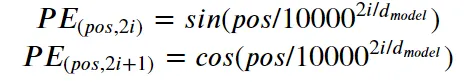

(1, 50, 512)


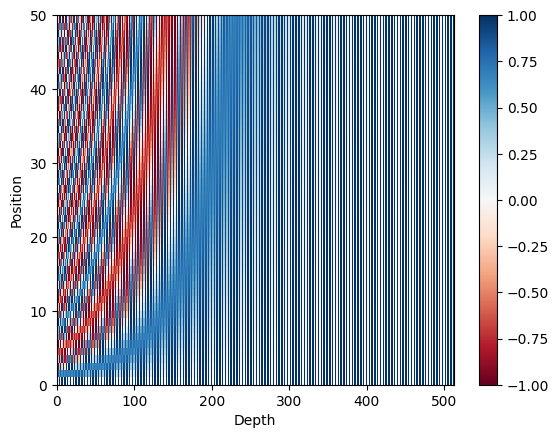

In [14]:
import matplotlib.pyplot as plt
# Positional encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis,:]

    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# **1. Pad Masking**
**Making all the padded tokens, self attention/attention calculation of a word with those paddings will be ignored**

* Here output dimn -> (batch_size, 1, 1, seq_len)
* for each 8 attention heads, for each query word it will be multiplied, thats why creating 1, 1 in the middle

In [15]:
# Masking

'''Mask all the pad tokens in the batch of sequence.
It ensures that the model does not treat padding as the input.
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(seq):
    """
    seq: padded sentence length (5)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Adding 2, 3 dimn using tf.newaxis, 2-> As this mask will be multiplied with each attention head and 3-> for each word in a sentance
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
# create_padding_mask(np.array([[1,2,3,0,0,0],[1,2,3,0,0,1]]))

# **2. Looakahead mask**
for the first word, its self attention calculation with be ignored with proceeding words i.e. second, third word and so on


In [16]:
# Looakahead mask

"""The look-ahead mask is used to mask the future tokens in a sequence.
In other words, the mask indicates which entries should not be used.
"""
def create_look_ahead_mask(size):
    """
    The look-ahead mask is used to mask the future tokens in a sequence
    """
    #band_part with this setting creates lower triangular matrix that's why subtracting from 1
    # [[0., 1., 1.],
    #  [0., 0., 1.],
    #  [0., 0., 0.]] output with size:3
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>



<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mstyle mathsize="1.44em">
    <mrow data-mjx-texclass="ORD">
      <mi>P</mi>
      <msub>
        <mi>E</mi>
        <mrow data-mjx-texclass="ORD">
          <mo stretchy="false">(</mo>
          <mi>p</mi>
          <mi>o</mi>
          <mi>s</mi>
          <mo>,</mo>
          <mn>2</mn>
          <mi>i</mi>
          <mo>+</mo>
          <mn>1</mn>
          <mo stretchy="false">)</mo>
        </mrow>
      </msub>
      <mo>=</mo>
      <mi>c</mi>
      <mi>o</mi>
      <mi>s</mi>
      <mo stretchy="false">(</mo>
      <mi>p</mi>
      <mi>o</mi>
      <mi>s</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msup>
        <mn>10000</mn>
        <mrow data-mjx-texclass="ORD">
          <mn>2</mn>
          <mi>i</mi>
          <mrow data-mjx-texclass="ORD">
            <mo>/</mo>
          </mrow>
          <msub>
            <mi>d</mi>
            <mrow data-mjx-texclass="ORD">
              <mi>m</mi>
              <mi>o</mi>
              <mi>d</mi>
              <mi>e</mi>
              <mi>l</mi>
            </mrow>
          </msub>
        </mrow>
      </msup>
      <mo stretchy="false">)</mo>
    </mrow>
  </mstyle>
</math>

# **3. SELF-ATTENTION Calculation**

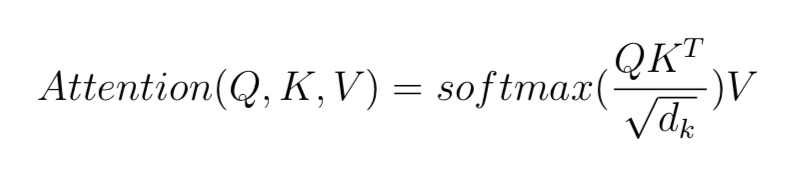

In [17]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Args:
    q: query shape == (..., seq_len_q, depth) # NOTE: depth=dk
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk. underroot d_model i.e. underroot(100)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever mask is set, make its logit value close to -INF
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# **4. MultiHeadAttention Calculation**
Its nothing but a RESHAPING !! :)

example :

1.if we have (64, 10, 512)->(BATCH, #words, embeddding) as input, after  
  passiing it though dense layer of size 512 we will get (64, 10, 512)

2.We have three such dense layers representing/for Q, K, V encodings.

3.(64, 10, 512) -> reshape -> (64, 8, 10 ,64) -> (BATCH, attention head, #words, encode) '64' is representing encoding of 512 -> 64 dimension

4.(64, 8, 10 ,64)->self-attention-code->(64, 8, 10 ,10) called attention weights, (64, 8, 10 ,64)

5.Concatenate such that 8*64 will be new dimension -> (64, 10, 512)

### **Beware embedding dimn must be divisible by no. of heads and always embedding_dimn/heads => encodin_dimn(here 64)**

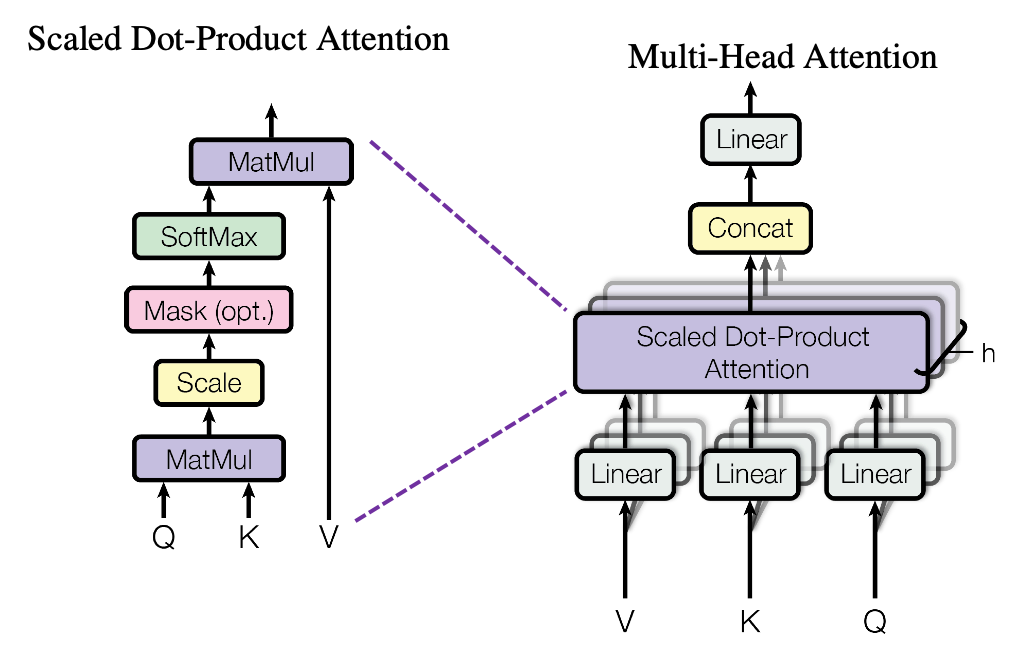

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights



# **5. ENCODER layer**
**-> self Multihead attention -> Residual+Norm -> Feed forward neural network -> Residual+Norm**

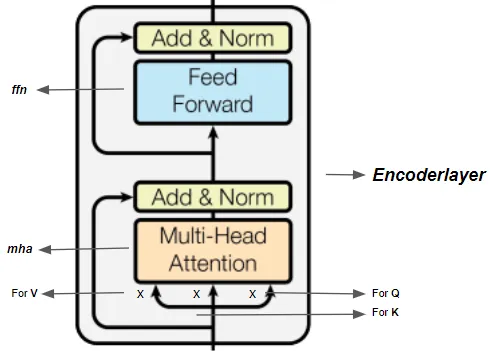

In [19]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# **6. ENCODER**
**-> Input embedding vector -> positional encoding -> Encoder layer**

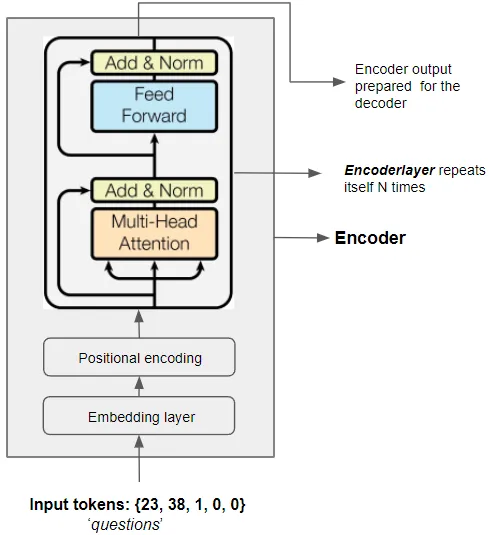

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Input Embedding Layer
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)

        # Postional Encoding Layer
        self.pos_encoding = positional_encoding(maximum_position_encoding,  self.d_model)

        # Multiple Encoding layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)  for _ in range(num_layers) ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)

        '''
        the below line : x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        helps ensure that the embedding vectors have a suitable scale with respect to the embedding dimension
        which can be beneficial for training the Transformer model.

        x = embedded_vector_of_x * sqrt(embedding_dimension)

        '''
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)

        return x

# **6. DECODER LAYER**
**-> self multihead attention -> residual+norm -> cross multihead attention(between E & D) -> residual+norm -> feed forward NN -> residual+norm**

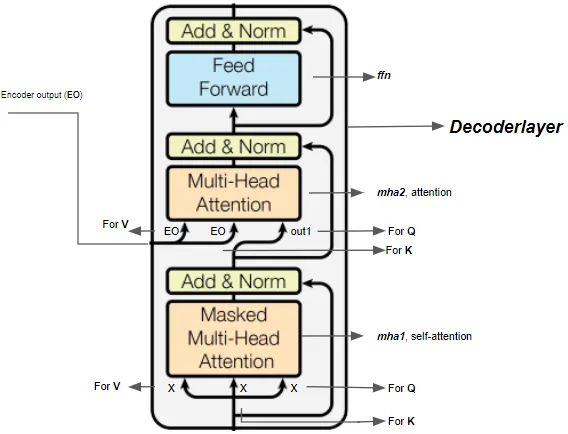

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

# **8. DECODER**
**-> Input embedding vector -> positional encoding -> Decoder layer**

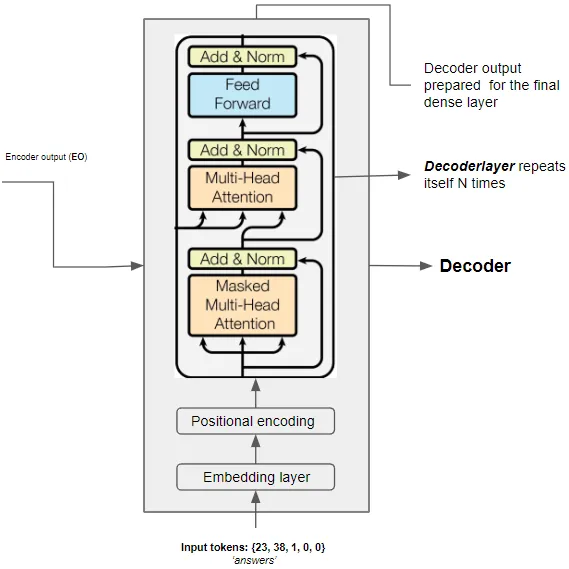

In [22]:

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Input Embedding Layer
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)

        # Postional Encoding Layer
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Multiple Decoding layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]

        # dictionary to Save Attention weights
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

# **9. TRANSFORMER**
## Nothing but encoder+decoder+dense layer
### (64,10,512) -> dense_layer -> (64,10,vocab_size)

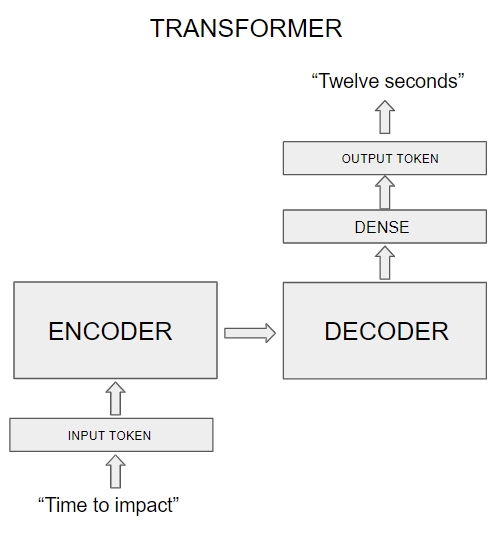

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

### **So to create a transformer architecture which is now everywhere in NLP models, we require only 9 STEPs :-O**

In [24]:
# tokenizer_a = joblib.load("tokenizer_a")
# tokenizer_q = joblib.load("tokenizer_q")

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

# **Custom learning rate, proposed in the paper**
## First learning rate will be high and then after some epochs it will be decreasing ONLY

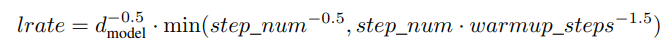

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [26]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# **See, increasing and then decreasing**

Text(0.5, 0, 'Train Step')

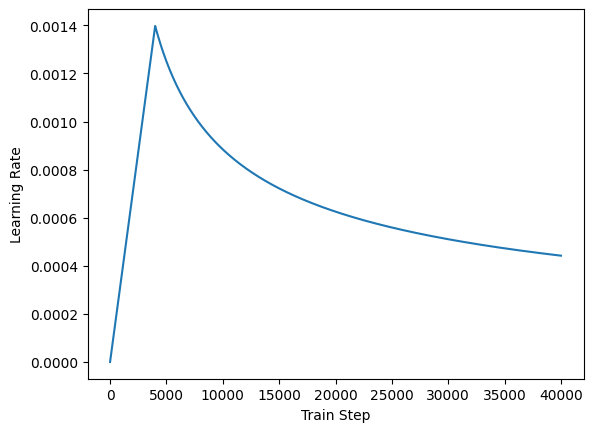

In [27]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Custom losss function, same as sparse categorical cross entropy but considers only no padded values

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Creating pad mask(encoder), pad mask(decoder), lookahead mask(decoder)

In [29]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

# **Saving model checkpoint**